<a href="https://colab.research.google.com/github/nomppy/colab-notebooks/blob/main/beam_net_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1v7FqhBh61LwpWFIWY1MMPDzI-GB9xcg7
!pip install tinycudann-1.7-cp310-cp310-linux_x86_64.whl
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!apt install nvidia-cuda-toolkit --yes

/bin/bash: gdown: command not found
Defaulting to user installation because normal site-packages is not writeable
Processing ./tinycudann-1.7-cp310-cp310-linux_x86_64.whl
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/home/sunken/code/colab-notebooks/tinycudann-1.7-cp310-cp310-linux_x86_64.whl'

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 10.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 310.2/838.3 MB 117.4 MB/s eta 0:00:05^C
     ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 313.8/838.3 MB 117.5 MB/s eta 0:00:05
ERROR: Operation cancelled by user
/bin/bash: apt: command not found


# imports & defaults

In [1]:
import torch
from torch import nn
# import tinycudann as tcnn
from tqdm import tqdm

import torchvision
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Literal, Sequence
from collections import OrderedDict

from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output, display
%load_ext tensorboard
# %tensorboard --logdir=logs

In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
writer = SummaryWriter()
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# fitting to sinuisoidal function

## data

torch.Size([500, 1]) torch.Size([500, 1])


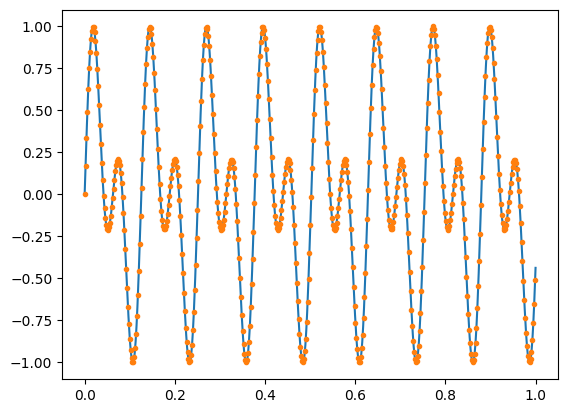

In [7]:
X_test = torch.linspace(0, 1, 1000).unsqueeze(-1)
omegas = [100, 50]
Y_test = torch.zeros_like(X_test)
for omega in omegas:
  Y_test += torch.sin(omega*X_test)

Y_test = Y_test / torch.max(Y_test)

train_data = [X_test[::2].to(device), Y_test[::2].to(device)]
print(train_data[0].shape, train_data[1].shape)

plt.plot(X_test, Y_test)
plt.plot(train_data[0].cpu(), train_data[1].cpu(), '.')
plt.show()


##mlp
Furst, we'll try to fit this function using a normal MLP with ~16M parameters

In [13]:
class NormalMLP(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims,
               activation=nn.ReLU(),
               sigmoid_output: bool = False):
    super().__init__()
    layers = []

    curr_dim = input_dim
    for dim in hidden_dims:
        layers.append(nn.Linear(curr_dim, dim))
        layers.append(activation)
        curr_dim = dim

    final_linear = nn.Linear(curr_dim, output_dim)
    layers.append(final_linear)
    if sigmoid_output:
      layers.append(nn.Sigmoid())

    self.net = nn.Sequential(*layers)

  def forward(self, x):
      return self.net(x)

## hash net

In [6]:
# import tinycudann as tcnn

# adapted from https://github.com/nerfstudio-project/nerfstudio/blob/main/nerfstudio/field_components/encodings.py#L310
class HashLayer(nn.Module):
  def __init__(self,
               input_dim: int,
               num_levels: int = 16,
               min_res: int = 16,
               max_res: int = 1024,
               log2_hashmap_size: int = 8,
               features_per_level: int = 2,
               hash_init_scale: float = 0.001,
               primes: Optional[Sequence[int]] = [97],
               implementation: Literal["tcnn", "torch"] = "tcnn",
               interpolation: Optional[Literal["Nearest", "Linear", "Smoothstep"]] = None,
  ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.num_levels = num_levels
        self.min_res = min_res
        self.features_per_level = features_per_level
        self.hash_init_scale = hash_init_scale
        self.log2_hashmap_size = log2_hashmap_size
        self.hash_table_size = 2**log2_hashmap_size
        self.primes = torch.tensor(primes)

        levels = torch.arange(num_levels)
        self.growth_factor = np.exp((np.log(max_res) - np.log(min_res)) / (num_levels - 1)) if num_levels > 1 else 1
        self.resolutions = torch.floor(min_res * self.growth_factor**levels)

        self.hash_offset = levels * self.hash_table_size

        self.tcnn_encoding = None
        self.hash_table = torch.empty(0)

        if implementation == "torch":
          self.build_hash_table()
        elif implementation == "tcnn":
          encoding_config = self.get_tcnn_encoding_config(
              num_levels=self.num_levels,
              features_per_level=self.features_per_level,
              log2_hashmap_size=self.log2_hashmap_size,
              min_res=self.min_res,
              growth_factor=self.growth_factor,
              interpolation=interpolation,
          )
          self.tcnn_encoding = tcnn.Encoding(
              n_input_dims=input_dim,
              encoding_config=encoding_config,
          )

        if self.tcnn_encoding is None:
            assert (
                interpolation is None or interpolation == "Linear"
            ), f"interpolation '{interpolation}' is not supported for torch encoding backend"

  @classmethod
  def get_tcnn_encoding_config(
      cls, num_levels, features_per_level, log2_hashmap_size, min_res, growth_factor, interpolation=None
  ) -> dict:
      """Get the encoding configuration for tcnn if implemented"""
      encoding_config = {
          "otype": "HashGrid",
          "n_levels": num_levels,
          "n_features_per_level": features_per_level,
          "log2_hashmap_size": log2_hashmap_size,
          "base_resolution": min_res,
          "per_level_scale": growth_factor,
      }
      if interpolation is not None:
          encoding_config["interpolation"] = interpolation
      return encoding_config

  def get_out_dim(self) -> int:
      return self.num_levels * self.features_per_level

  def build_hash_table(self):
      self.hash_table = torch.rand(size=(self.hash_table_size * self.num_levels, self.features_per_level)) * 2 - 1
      self.hash_table *= self.hash_init_scale
      self.hash_table = nn.Parameter(self.hash_table)

  def hash_fn(self, in_tensor):
    assert self.input_dim == len(self.primes), 'Input dimension must match number of primes'

    if self.input_dim == 1:
      return ((in_tensor.squeeze() * self.primes[0]) % self.hash_table_size) + self.hash_offset

    in_tensor = in_tensor * self.primes.to(in_tensor.device)
    x = torch.bitwise_xor(in_tensor[:, 0], in_tensor[:, 1])
    for d in range(self.input_dim - 2):
      x = torch.bitwise_xor(x, in_tensor[:, d + 2])
    return (x % self.hash_table_size) + self.hash_offset

  def torch_forward(self, x):
    if x.dim() == 1:
      x = x.unsqueeze(-1)

    x_proj = x[..., None, :self.input_dim] # (..., 1, D)
    x_scaled = x_proj * self.resolutions.view(-1, 1).to(x.device) # (..., L, D)
    scaled_c = torch.ceil(x_scaled).type(torch.int32)
    scaled_f = torch.floor(x_scaled).type(torch.int32)

    offsets = x_scaled - scaled_f # (..., L, D)

    if self.input_dim == 1:
      hashed_0 = self.hash_fn(scaled_c) # (..., L)
      hashed_1 = self.hash_fn(scaled_f)
      features_0 = self.hash_table[hashed_0] # (..., L, F)
      features_1 = self.hash_table[hashed_1]
      encoded = (features_0 * (1 - offsets) + features_1 * offsets) # (..., L, F)
      return torch.flatten(encoded, start_dim=-2) # (..., L*F)
    elif self.input_dim == 2:
      hashed_0 = self.hash_fn(scaled_c)
      hashed_1 = self.hash_fn(torch.cat([scaled_f[..., 0:1], scaled_c[..., 1:2]], dim=-1))  # Bottom-right
      hashed_2 = self.hash_fn(scaled_f)
      hashed_3 = self.hash_fn(torch.cat([scaled_c[..., 0:1], scaled_f[..., 1:2]], dim=-1))  # Top-left

      f_0 = self.hash_table[hashed_0] # (..., L, F)
      f_1 = self.hash_table[hashed_1]
      f_2 = self.hash_table[hashed_2]
      f_3 = self.hash_table[hashed_3]

      f_01 = (f_0 * (1 - offsets[..., 0:1]) + f_1 * offsets[..., 0:1]) # (..., L, F)
      f_23 = (f_2 * (1 - offsets[..., 0:1]) + f_3 * offsets[..., 0:1])

      encoded = (f_01 * (1 - offsets[..., 1:2]) + f_23 * offsets[..., 1:2])
      return torch.flatten(encoded, start_dim=-2) # (..., L*F)

  def forward(self, in_tensor):
    if self.tcnn_encoding is not None:
      return self.tcnn_encoding(in_tensor)
    return self.torch_forward(in_tensor)

def spatial_hash_1d(x, prime, T):
  return (x * prime) % T
  # try torch remainder?

class HashLayer1D(nn.Module):
  def __init__(self, levels, dim_features, N_min=2, N_max=2**8, prime=937, T=2**8):
    super().__init__()
    self.levels = levels
    self.dim_features = dim_features
    self.N_min = N_min
    self.N_max = N_max
    self.prime = prime
    self.T = T # size of hash table
    # self.features = nn.Parameter(torch.randn(levels, T, dim_features)) # (L, T, F)
    self.features = nn.ParameterList(
        [ nn.Parameter(torch.rand(T, dim_features)) for i in range(levels)]
    )
    self.b = np.exp((np.log(N_max) - np.log(N_min))/(levels-1))
    self.N = torch.tensor(
        [N_min * self.b**i for i in range(levels)], device=device) # (L)

  def forward(self, x):
    assert x.dim() <= 2, 'Input must be 1D or batched 1D'
    if x.dim() == 1:
      x = x.unsqueeze(-1)

    x_proj = x[:, 0].unsqueeze(-1) # (B, 1)
    x_scaled_N = x_proj * self.N # (B, L)
    x_rounded = [torch.floor(x_scaled_N).long(), torch.ceil(x_scaled_N).long()]
    idx_lower = spatial_hash_1d(x_rounded[0], self.prime, self.T) # (B, L)
    idx_upper = spatial_hash_1d(x_rounded[1], self.prime, self.T)
    out = []
    for i in range(self.levels):
      out.append(0.5 * (torch.gather(self.features[i], 0, idx_lower[:,i].unsqueeze(-1).expand(-1, self.dim_features)) +
                        torch.gather(self.features[i], 0, idx_upper[:,i].unsqueeze(-1).expand(-1, self.dim_features))))
    return torch.cat(out, dim=-1) #(B, L*F)
    # return torch.cat([0.5*(self.features[i][idx_lower[:,i]] +
    #                   self.features[i][idx_upper[:,i]])
    #                   for i in range(self.levels)], dim=-1) #(B, L*F)

In [7]:
class HashNet(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims,
               activation=nn.ReLU()):
    super().__init__()
    layers = []

    curr_dim = input_dim
    fc, hash = 0, 0
    for dim in hidden_dims:
      if type(dim) == int:
        layers.append((f'fc_{fc}', nn.Linear(curr_dim, dim)))
        layers.append((f'act_{fc}', activation))
        curr_dim = dim
        fc += 1
      elif type(dim) == str:
        L, F, N_max, *_ = [int(p) for p in dim[1:].split(',')]
        layers.append((f'hash_{hash}',
                       HashLayer(input_dim=1,
                                num_levels=L,
                                features_per_level=F,
                                max_res=N_max,
                                log2_hashmap_size=10,
                                implementation='torch')))
        # layers.append(HashLayer1D(levels=L,
        #                           dim_features=F,
        #                           N_max=N_max,
        #                           T=64))
        curr_dim = L*F
        hash += 1

    final_linear = ('output_layer', nn.Linear(curr_dim, output_dim))
    layers.append(final_linear)

    self.net = nn.Sequential(OrderedDict(layers))
    self.apply(self.kaiming_init)

  def kaiming_init(self, module):
    if isinstance(module, nn.Linear):
      nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
      if module.bias is not None:
        nn.init.zeros_(module.bias)

  def forward(self, x):
      return self.net(x)

In [8]:
a,b,c,*_ = [int(p) for p in '#16,2,64'[1:].split(',')]
b

2

In [9]:
print(model)
print(np.sum([p.numel() for p in model.parameters()]))


KeyboardInterrupt



In [ ]:
model = HashNet(input_dim=1, output_dim=1, hidden_dims=['#16, 2, 256', 256]) # L, F, N_max
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()


# plt.imshow(model.net[2].features[0].detach().numpy())
model = model.to(device)

activations, gradients = {}, {}
def save_activation(name):
  def hook(model, input, output):
    activations[name] = output.detach().cpu()
  return hook

def save_gradients(name):
  def hook(model, grad_in, grad_out):
    gradients[name] = grad_out[0].detach().cpu()
  return hook

for name, layer in model.net.named_modules():
  if type(layer) == nn.Linear or type(layer) == HashLayer:
    layer.register_forward_hook(save_activation(name))
    layer.register_full_backward_hook(save_gradients(name))
# [d.to(device) for d in train_data]

# for layer in model.net[1:]:
#   for param in layer.parameters():
#     param.requires_grad = False

In [ ]:
feature_map_grads = []
linear_grad = []

epochs = 500

for epoch in range(epochs):
  model.train()
  optimizer.zero_grad()

  pred = model(train_data[0])
  model_loss = loss(pred, train_data[1])

  model_loss.backward()
  optimizer.step()

  with torch.no_grad():
    # for param in model.net[2].features.parameters():
    #   if param.grad is not None:
    #     feature_map_grads.append(param.grad.norm().item())
    # if model.net[0].weight.grad is not None:
    #   linear_grad.append(model.net[1].weight.norm().item())

    if (epoch % 100) == 0:
        print(f'Epoch {epoch} | Loss: {model_loss}')


model.eval()

plt.plot(X_test, model(X_test.to(device)).cpu().detach().numpy())
plt.plot(train_data[0].cpu(), train_data[1].cpu(), '.')
plt.show()
# plt.imshow(model.net[2].features[0].detach().cpu().numpy())


In [ ]:
for (layer, activation) in activations.items():
  if layer == 'output_layer':
    continue
  hist, bins = np.histogram(activation.ravel(), bins=50, density=True)
  bin_centers = (bins[:-1]  + bins[1:]) / 2
  plt.plot(bin_centers, hist, label=layer)
plt.legend()
plt.show()


In [ ]:
for (layer, gradient) in gradients.items():
  if layer == 'output_layer':
    continue
  hist, bins = np.histogram(gradient.ravel(), bins=50, density=True)
  bin_centers = (bins[:-1]  + bins[1:]) / 2plot(bin_centers, hist, label=layer)
plt.legend()
plt.show()


## beam network definitions
name is wip

In [125]:
import torch.nn.functional as F
# adapted from https://github.com/nerfstudio-project/nerfstudio/blob/main/nerfstudio/field_components/encodings.py#L310
class BeamLayer(nn.Module):
  def __init__(self,
               input_dim: int,
               num_levels: int = 16,
               min_res: int = 16,
               max_res: int = 1024,
               features_per_level: int = 2,
               init_scale: float = 0.001,
               interpolation: Optional[Literal["nearest", "bilinear", "bicubic"]] = None,
  ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.num_levels = num_levels
        self.min_res = min_res
        self.max_res = max_res
        self.features_per_level = features_per_level
        self.init_scale = init_scale

        levels = np.arange(num_levels)
        self.growth_factor = np.exp((np.log(max_res) - np.log(min_res)) / (num_levels - 1)) if num_levels > 1 else 1
        self.resolutions = np.floor(min_res * self.growth_factor**levels).astype(int)
        self.build_lookup()

  def build_lookup(self):
      # self.feature_grid = torch.rand(
          # size=(self.features_per_level, self.max_res, self.max_res))
      self.feature_grid = nn.ParameterList(
        [ nn.Parameter(torch.randn(self.features_per_level, res, res, device=device))
        for res in self.resolutions]) # [L, F, N, N]
      # self.feature_grid *= self.init_scale
      # self.feature_grid = nn.Parameter(self.feature_grid)

  def forward(self, x):
    if x.dim() == 1:
      x = x.unsqueeze(-1)
    mins, _ = x.min(dim=0, keepdim=True)
    maxs, _ = x.max(dim=0, keepdim=True)
    # print('mins', mins[0], 'maxs', maxs[0])
    # x_normalized = 2 * ( x - mins )
    # print(x_normalized[0])
    # x_normalized = x_normalized / (maxs - mins) - 1
    # print(x_normalized[0])
    # x_normalized = torch.clamp(x, -1, 1)
    # x_normalized = x
    # print(x_normalized.shape)
    x_proj = x[None, :, None, :2] # (1, B, 1, 2)
    # print(x_proj.shape)
    x_interpolated = torch.zeros(self.num_levels,
                                 self.features_per_level,
                                 x.shape[0], device=device) # (L, F, B)
    for l in range(self.num_levels):
      x_interpolated[l] = F.grid_sample(self.feature_grid[l].unsqueeze(0),
                                        x_proj,
                                        mode='bilinear',
                                        align_corners=True).squeeze()
                                        # (1, F, B, 1) -> (F, B)

    return torch.flatten(x_interpolated, start_dim=0, end_dim=1).transpose(0, 1) # [B, F]

class BeamLayerGrad(torch.autograd.Function):
  """
    Autograd function implementing numerical gradient calculation for beam layer
  """

  @staticmethod
  def forward(ctx, x, feature_grid):
    pass
  @staticmethod
  def backward(ctx, grad_output):
    pass

class BeamNet(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims,
               final_linear: bool = True,
               sigmoid_output: bool = False,
               activation=nn.ReLU()):
    super().__init__()
    layers = []

    curr_dim = input_dim
    fc, beam = 0, 0
    for dim in hidden_dims:
      if type(dim) == int:
        layers.append((f'fc_{fc}', nn.Linear(curr_dim, dim)))
        layers.append((f'act_{fc}', activation))
        curr_dim = dim
        fc += 1
      elif type(dim) == str:
        G, L, F, N_max, *_ = [int(p) for p in dim[1:].split(',')]
        layers.append((f'guide_{beam}', nn.Linear(curr_dim, G)))
        layers.append((f'guide_{beam}_act', nn.Tanh()))
        layers.append((f'beam_{beam}',
                       BeamLayer(input_dim=2,
                                num_levels=L,
                                features_per_level=F,
                                max_res=N_max)))
        curr_dim = L*F
        beam += 1
    if final_linear:
      final_linear = ('fc_final', nn.Linear(curr_dim, output_dim))
      layers.append(final_linear)

    if sigmoid_output:
      layers.append(('sigmoid_out', nn.Sigmoid()))

    self.net = nn.Sequential(OrderedDict(layers))
    self.apply(self.kaiming_init)

  def kaiming_init(self, module):
    if isinstance(module, nn.Linear):
      nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
      if module.bias is not None:
        nn.init.zeros_(module.bias)

  def zero_init(self, module):
    if isinstance(module, nn.Linear):
      nn.init.zeros_(module.weight)
      if module.bias is not None:
        nn.init.zeros_(module.bias)

  def forward(self, x):
      return self.net(x)

In [119]:
# tensorboard helper functions

def plot_pred(net, x):
  pred = net(x)
  fig = plt.figure(figsize=(12,10))
  plt.plot(x.cpu(), pred.cpu().detach().numpy())
  return fig

def plot_gradient_flow(named_parameters):
  ave_grads = []
  layers = []
  for n, p in named_parameters:
      if(p.requires_grad) and ("bias" not in n):
          layers.append(n)
          ave_grads.append(p.grad.abs().mean().cpu())
  plt.plot(ave_grads, color="b", linewidth=3, alpha=0.3)
  plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
  plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
  plt.xlim(xmin=0, xmax=len(ave_grads))
  plt.xlabel("Layers")
  plt.ylabel("average gradient")
  plt.title("Gradient flow")
  plt.grid(True)
  # return fig

## test/MLP

In [ ]:
# model = torchvision.ops.MLP(1, [256, 256, 256, 256, 1])
model = NormalMLP(1, 1, [2048]*5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()

epochs = 10000

model = model.to(device)

print(np.sum([p.numel() for p in model.parameters()]))

In [ ]:
for epoch in tqdm(range(epochs)):
  model.train()
  optimizer.zero_grad()

  pred = model(train_data[0])
  model_loss = loss(pred, train_data[1])

  model_loss.backward()
  optimizer.step()

  if (epoch % 100) == 0:
    print(f'Epoch {epoch} | Loss: {model_loss}')
    plt.plot(train_data[0].cpu(), pred.detach().cpu())
    plt.show()

model.eval()
model.cpu()

plt.plot(X_test, model(X_test).detach().numpy())
plt.plot(train_data[0].cpu(), train_data[1].cpu(), '.')
plt.show()

## test/beam

In [133]:
model = BeamNet(input_dim=1, output_dim=1,
                hidden_dims=['#16,4,32,256', 256],
                # hidden_dims=[
                # activation=nn.Tanh(),
                activation=nn.ReLU(),
               ) # L, F, N_max
# model = BeamNet(input_dim=1, output_dim=1, hidden_dims=[256, 256]*4) # G, L, F, N_max

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = nn.MSELoss()

# plt.imshow(model.net[2].features[0].detach().numpy())

activations, gradients, inputs = {}, {}, {}
def save_activation(name):
  def hook(model, input, output):
    activations[name] = output.detach().cpu()
  return hook

def save_gradients(name):
  def hook(model, grad_in, grad_out):
    gradients[name] = grad_out[0].mean().detach().cpu()
  return hook

def save_inputs(name):
  def hook(model, input, output):
    inputs[name] = input[0].detach().cpu()
  return hook

for name, layer in model.net.named_modules():
  if type(layer) == nn.Linear or type(layer) == BeamLayer:
    layer.register_forward_hook(save_activation(name))
    layer.register_full_backward_hook(save_gradients(name))
    layer.register_forward_hook(save_inputs(name))


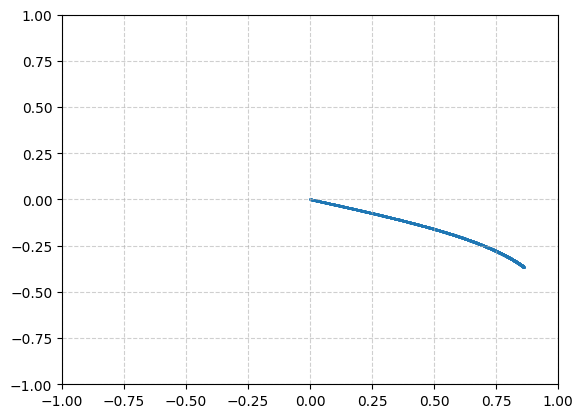

In [138]:
# visualize where beam lands
model = model.cuda()
pred = model(X_test.cuda())
# print(pred[:10])

# for n, a in inputs.items():
#     print(n, a[:10], a.max(), a.min())
out = inputs['beam_0']
plt.scatter(out[:, 0], out[:, 1], marker="o", s=1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [128]:
print(model)
np.sum([p.numel() for p in model.parameters()])

BeamNet(
  (net): Sequential(
    (fc_0): Linear(in_features=1, out_features=4, bias=True)
    (act_0): ReLU()
    (guide_0): Linear(in_features=4, out_features=16, bias=True)
    (guide_0_act): Tanh()
    (beam_0): BeamLayer(
      (feature_grid): ParameterList(
          (0): Parameter containing: [torch.float32 of size 32x16x16 (cuda:0)]
          (1): Parameter containing: [torch.float32 of size 32x40x40 (cuda:0)]
          (2): Parameter containing: [torch.float32 of size 32x101x101 (cuda:0)]
          (3): Parameter containing: [torch.float32 of size 32x255x255 (cuda:0)]
      )
    )
    (fc_1): Linear(in_features=128, out_features=256, bias=True)
    (act_1): ReLU()
    (fc_final): Linear(in_features=256, out_features=1, bias=True)
  )
)


2499993

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | Loss: 0.0001749692892190069


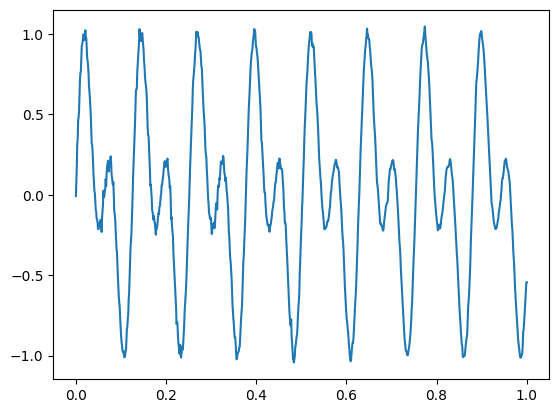

 16%|█▋        | 82/500 [00:00<00:01, 211.29it/s]

Epoch 100 | Loss: 0.00012759868695866317


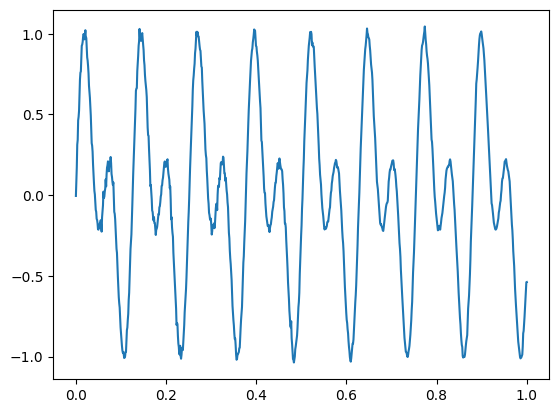

 37%|███▋      | 186/500 [00:01<00:01, 216.42it/s]

Epoch 200 | Loss: 9.444478928344324e-05


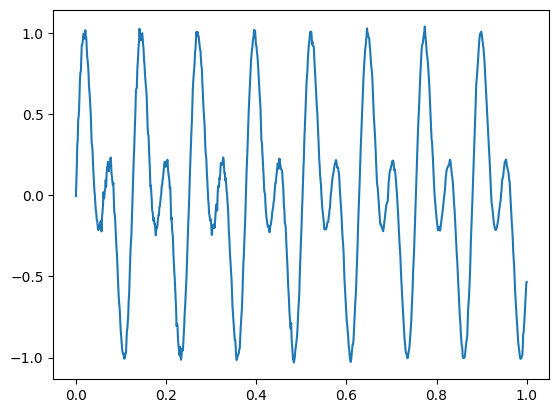

 58%|█████▊    | 292/500 [00:01<00:00, 217.02it/s]

Epoch 300 | Loss: 7.103300595190376e-05


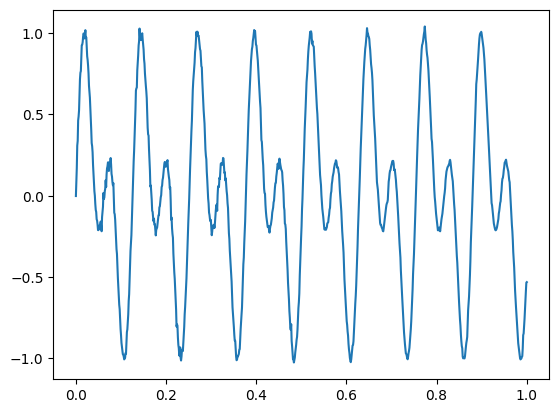

 80%|███████▉  | 398/500 [00:02<00:00, 218.12it/s]

Epoch 400 | Loss: 5.407540811575018e-05


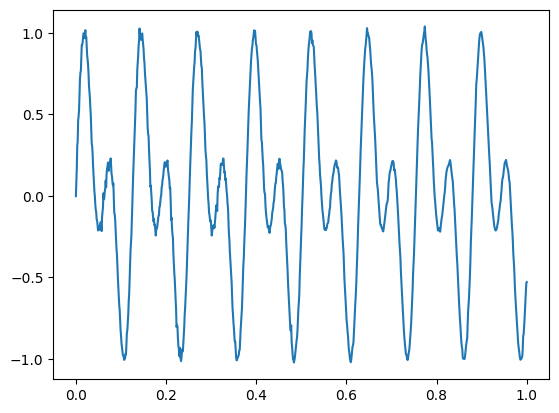

100%|██████████| 500/500 [00:02<00:00, 184.93it/s]


In [137]:
feature_map_grads = []
linear_grad = []

epochs = 500
model = model.to(device)

X_test_2d = X_test.repeat(1, 2).to(device)
X_test = X_test.to(device)
X_train_2d = train_data[0].repeat(1, 2).to(device)

# plt.ion()
# pred_fig, pred_ax = plt.subplots()
# pred_line, = pred_ax.plot(train_data[0].cpu(), np.zeros_like(train_data[0].cpu()))
# pred_ax.set_title(f'Epoch 0')

for epoch in tqdm(range(epochs)):
  model.train()
  optimizer.zero_grad()

  pred = model(train_data[0])
  model_loss = loss(pred, train_data[1])
  writer.add_scalar('Loss/train', model_loss, epoch)

  model_loss.backward()
  optimizer.step()

  with torch.no_grad():
    if (epoch % 100) == 0:
        print(f'Epoch {epoch} | Loss: {model_loss}')
        plt.plot(X_test.cpu(), model(X_test).cpu().detach().numpy())
        plt.show()

        # writer.add_figure('Gradient flow',
        # writer.add_figure('Prediction', plot_pred(model, X_test), global_step=epoch)
        # plot_gradient_flow(model.named_parameters())
        # pred_line.set_ydata(pred.detach().cpu())
        # pred_ax.set_title(f'Epoch {epoch}')
        # pred_fig.canvas.draw()
        # pred_fig.canvas.flush_events()
        # writer.add_figure('Gradient flow', plot_gradient_flow(model.named_parameters()))

plt.ioff()
plt.show()
model.eval()

writer.flush()
# plt.plot(X_test, model(X_test_2d).cpu().detach().numpy())
# plt.plot(train_data[0].cpu(), train_data[1].cpu(), '.')
# plt.show()


In [ ]:
for (layer, activation) in activations.items():
  if layer == 'output_layer':
    continue
  hist, bins = np.histogram(activation.ravel(), bins=50, density=True)
  bin_centers = (bins[:-1]  + bins[1:]) / 2
  plt.plot(bin_centers, hist, label=layer)
plt.legend()
plt.show()

In [ ]:
for (layer, gradient) in gradients.items():
  if layer == 'output_layer':
    continue
  hist, bins = np.histogram(gradient.ravel(), bins=50, density=True)
  bin_centers = (bins[:-1]  + bins[1:]) / 2
  plt.plot(bin_centers, hist, label=layer)
plt.legend()
plt.show()


# 2d image overfitting

## data

/tmp/ipykernel_1417436/1833074087.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3]


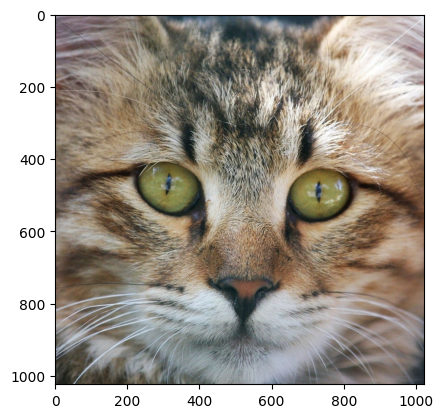

(1024, 1024, 3)


In [139]:
# Download image, take a square crop from the center
import imageio

# image_url = 'https://i.ytimg.com/vi/SQJrYw1QvSQ/maxresdefault.jpg'
image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'

img = imageio.imread(image_url)[..., :3]
h, w = img.shape[:2]
crop = min(h, w)
top = (h - crop) // 2
left = (w - crop) // 2
bottom = top + crop
right = left + crop
img = img[top:bottom, left:right] / 255.0
plt.imshow(img)
plt.show()
print(img.shape)

/home/sunken/.conda/envs/vision/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1048576, 2])
torch.Size([1024, 1024, 3])
torch.Size([262144, 2])
torch.Size([262144, 3])


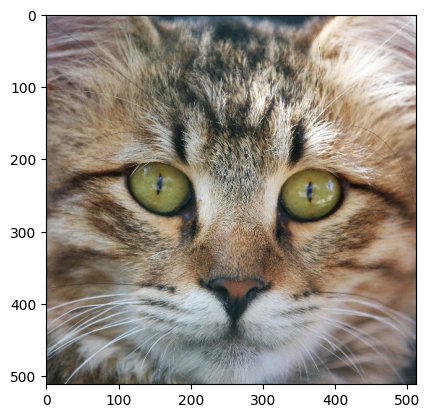

In [140]:
# Create input pixel coordinates in the unit square
coords = torch.linspace(-1, 1, img.shape[0], device=device)
x_test = torch.stack(torch.meshgrid(coords, coords), -1)
img = torch.tensor(img).type_as(x_test)
test_data = [x_test.reshape(-1, 2), img]
train_data = [x_test[::2, ::2].reshape(-1, 2), img[::2, ::2].reshape(-1, 3)]
print(test_data[0].shape)
print(img.shape)
print(train_data[0].shape)
print(train_data[1].shape)
# plt.imshow(train_data[1].reshape(360, 360, 3).cpu())
plt.imshow(train_data[1].reshape(512, 512, 3).cpu())

plt.show()

## pos enc

In [ ]:
def pos_enc(x, B):
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T.cuda()
    return torch.cat([torch.cos(x_proj),
                      torch.sin(x_proj)], dim=-1)

def nerf_posenc(x, L_embed):
  rets = [x]
  for i in range(L_embed):
    for fn in [torch.sin, torch.cos]:
      rets.append(fn(2.**i * x))
  return torch.cat(rets, -1)

def gen_Bdict(mapping_size=10):
  assert mapping_size % 2 == 0

  D = int(mapping_size)
  B_dict = {}
  B_gauss = torch.randn((D, 2))

  for scale in [1., 10., 32., 100.]:
    B_dict[f'gauss_{scale}'] = B_gauss * scale

  return B_dict

## test/MLP

In [ ]:
# model = torchvision.ops.MLP(1, [256, 256, 256, 256, 1])
embedding_size = 256
B_dict = gen_Bdict(embedding_size)
B = B_dict['gauss_10.0']
mlp2d = NormalMLP(embedding_size*2, 3, [256]*4, sigmoid_output=True)
optimizer = torch.optim.Adam(mlp2d.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2500, gamma=0.5)
loss = nn.MSELoss()

epochs = 1000

mlp2d = mlp2d.to(device)

def preforward_pos_enc(module, input):
  x = input[0]
  # return nerf_posenc(x, freqs)
  return pos_enc(x, B)

posenc_handler = mlp2d.register_forward_pre_hook(preforward_pos_enc)
print(np.sum([p.numel() for p in mlp2d.parameters()]))
print(mlp2d)

In [ ]:
plt.imshow(train_data[1].reshape(360, 360, 3).cpu())
plt.show()

In [ ]:
import random
mlp2d.train()
batch_size = 64
num_training_samples = train_data[0].shape[0]
perm = random.sample(range(num_training_samples), num_training_samples)

# x_train = train_data[0]
# y_train = train_data[1]
print(train_data[0].shape)
print(train_data[1].shape)
for epoch in tqdm(range(epochs)):
  for j in range(0, num_training_samples, batch_size):
    idx = perm[j:j+batch_size]
    x_train = train_data[0][idx]
    y_train = train_data[1][idx]

    optimizer.zero_grad()
    pred = mlp2d(x_train)
    model_loss = loss(pred, y_train)

    model_loss.backward()
    optimizer.step()
    scheduler.step()

  if (epoch % 100) == 0:
    with torch.no_grad():
      print(f'Epoch {epoch} | Loss: {model_loss}')
      test_pred = mlp2d(test_data[0]).reshape(1024, 1024, 3)
      plt.imshow(test_pred.cpu().detach().numpy())
      plt.show()

# model.eval()

# plt.plot(X_test, model(X_test).detach().numpy())
# plt.plot(train_data[0].cpu(), train_data[1].cpu(), '.')
# plt.show()

## test/beam

In [ ]:
model2d = BeamNet(input_dim=2, output_dim=3,
                  hidden_dims=['#4,2,8,256', 256],
                  # hidden_dims=[256]*4,
                  sigmoid_output=True,
                  activation=nn.ReLU()) # L, F, N_max
# model = BeamNet(input_dim=1, output_dim=1, hidden_dims=[256, 256]*4) # L, F, N_max

model2d = model2d.to(device)
optimizer = torch.optim.Adam(model2d.parameters(), lr=1e-3)
loss = nn.MSELoss()

# plt.imshow(model.net[2].features[0].detach().numpy())

activations, gradients, inputs = {}, {}, {}
def save_activation(name):
  def hook(model, input, output):
    activations[name] = output.detach().cpu()
  return hook

def save_gradients(name):
  def hook(model, grad_in, grad_out):
    gradients[name] = grad_out[0].mean().detach().cpu()
  return hook

def save_inputs(name):
  def hook(model, input, output):
    inputs[name] = input[0].detach().cpu()
  return hook

for name, layer in model2d.net.named_modules():
  if type(layer) == BeamLayer:
    # layer.register_forward_hook(save_activation(name))
    # layer.register_full_backward_hook(save_gradients(name))
    layer.register_forward_hook(save_inputs(name))


In [210]:
print(model2d)
print(np.sum([p.numel() for p in model2d.parameters()]))
# pred = model2d(test_data[0]).reshape(720,720,3)
# plt.imshow(pred.cpu().detach().numpy())
# plt.show()

BeamNet(
  (net): Sequential(
    (guide_0): Linear(in_features=2, out_features=4, bias=True)
    (guide_0_act): Tanh()
    (beam_0): BeamLayer(
      (feature_grid): ParameterList(
          (0): Parameter containing: [torch.float32 of size 8x16x16 (cuda:0)]
          (1): Parameter containing: [torch.float32 of size 8x256x256 (cuda:0)]
      )
    )
    (fc_0): Linear(in_features=16, out_features=256, bias=True)
    (act_0): ReLU()
    (fc_final): Linear(in_features=256, out_features=3, bias=True)
    (sigmoid_out): Sigmoid()
  )
)
531471


In [186]:
lookup_before = []
for g in model2d.net.beam_0.feature_grid:
    lookup_before.append(g.detach().cpu().numpy())

In [188]:
print(lookup_before[-1].shape)

(4, 256, 256)


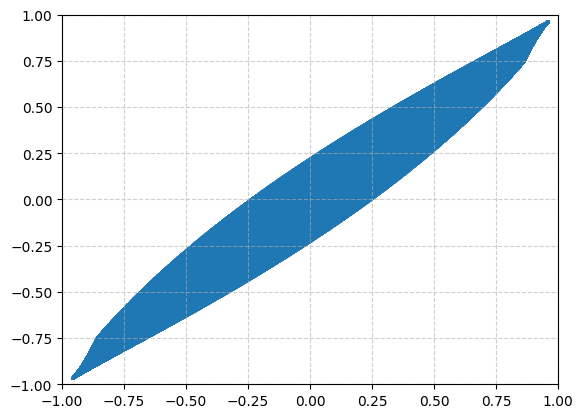

In [192]:
# visualize where beam lands
model2d = model2d.cuda()
pred = model2d(test_data[0].cuda())
# print(pred[:10])

# for n, a in inputs.items():
#     print(n, a[:10], a.max(), a.min())
out = inputs['beam_0']
plt.scatter(out[:, 0], out[:, 1], marker="o", s=1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 | Loss: 0.0697820708155632


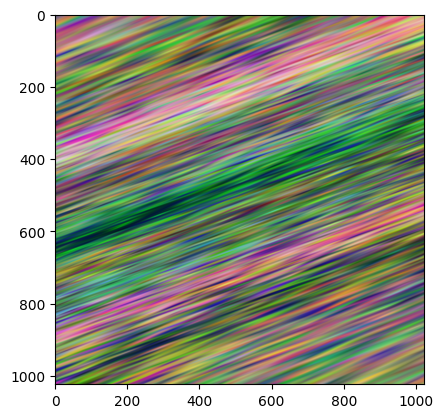

  9%|▉         | 91/1000 [00:01<00:10, 89.25it/s]

Epoch 100 | Loss: 0.027093153446912766


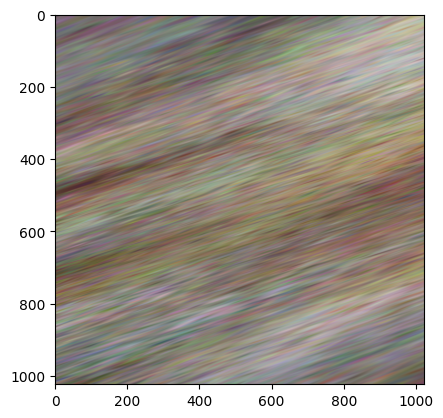

 19%|█▉        | 191/1000 [00:02<00:09, 88.94it/s]

Epoch 200 | Loss: 0.02180987223982811


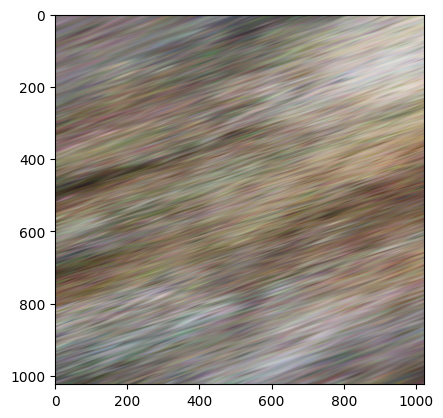

 29%|██▉       | 291/1000 [00:04<00:07, 88.91it/s]

Epoch 300 | Loss: 0.017924930900335312


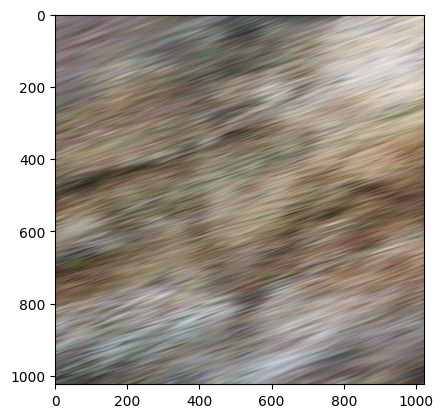

 39%|███▉      | 391/1000 [00:05<00:06, 89.00it/s]

Epoch 400 | Loss: 0.014866948127746582


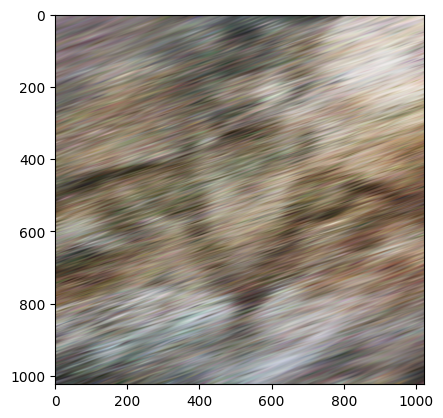

 49%|████▉     | 491/1000 [00:06<00:05, 89.12it/s]

Epoch 500 | Loss: 0.01266053132712841


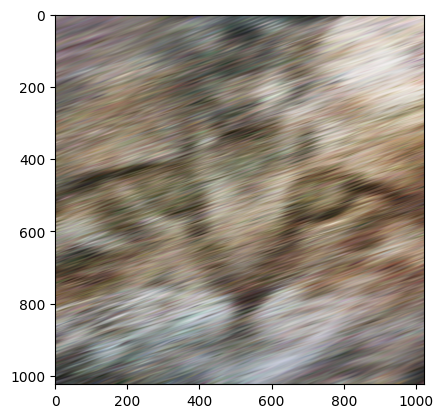

 59%|█████▉    | 591/1000 [00:08<00:04, 89.03it/s]

Epoch 600 | Loss: 0.011129399761557579


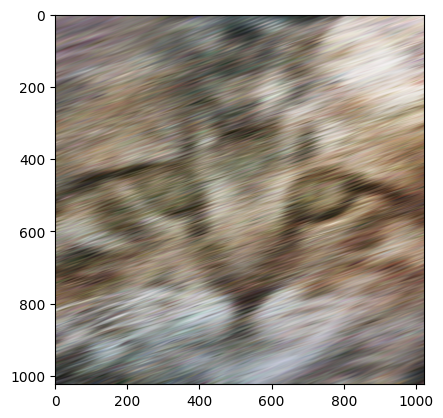

 69%|██████▉   | 691/1000 [00:09<00:03, 88.97it/s]

Epoch 700 | Loss: 0.010058934800326824


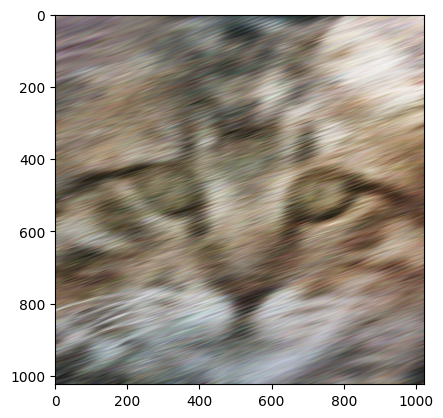

 79%|███████▉  | 791/1000 [00:11<00:02, 88.98it/s]

Epoch 800 | Loss: 0.009272984229028225


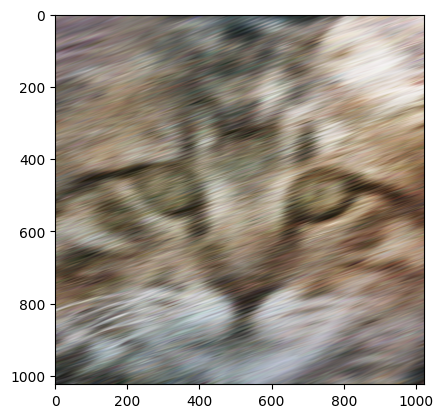

 89%|████████▉ | 891/1000 [00:12<00:01, 88.96it/s]

Epoch 900 | Loss: 0.008660392835736275


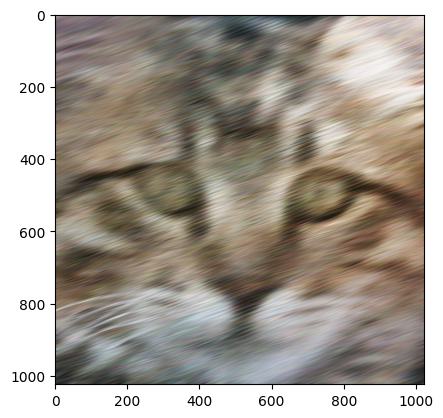

100%|██████████| 1000/1000 [00:13<00:00, 71.68it/s]


In [211]:
from tqdm import tqdm

feature_map_grads = []
linear_grad = []

epochs = 1000

model2d.train()

for epoch in tqdm(range(epochs)):
  optimizer.zero_grad()

  pred = model2d(train_data[0])
  model_loss = loss(pred, train_data[1])

  model_loss.backward()
  optimizer.step()

  with torch.no_grad():
    # for param in model.net[2].features.parameters():
    #   if param.grad is not None:
    #     feature_map_grads.append(param.grad.norm().item())
    # if model.net[0].weight.grad is not None:
    #   linear_grad.append(model.net[1].weight.norm().item())

    if (epoch % 100) == 0:
        print(f'Epoch {epoch} | Loss: {model_loss}')
        test_pred = model2d(test_data[0]).reshape(1024, 1024, 3)
        plt.imshow(test_pred.cpu().detach().numpy())
        plt.show()

# model2d.eval()

# plt.plot(X_test, model2d(X_test.to(device)).cpu().detach().numpy())
# plt.plot(train_data[0].cpu(), train_data[1].cpu(), '.')
# plt.show()
# plt.imshow(model.net[2].features[0].detach().cpu().numpy())


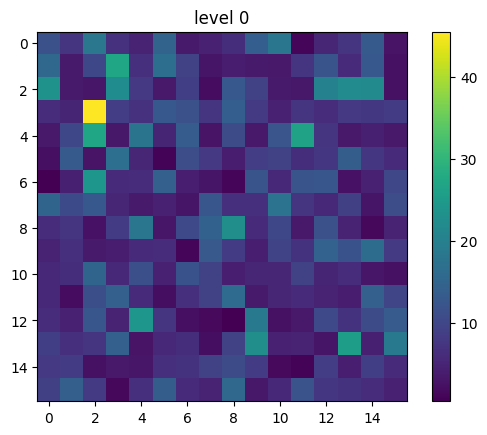

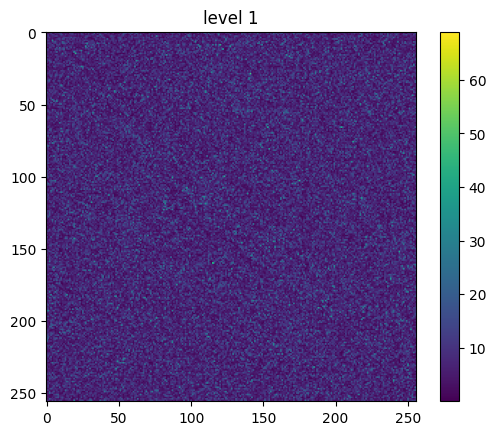

In [208]:
diff = model2d.net.beam_0.feature_grid[1].detach().cpu().numpy() - lookup_before[1]
num_c = diff.shape[0]
for i, g in enumerate(model2d.net.beam_0.feature_grid):
    diff = g.detach().cpu().numpy() - lookup_before[i]
    plt.imshow(np.sum(diff**2, axis=0), cmap='viridis')
    plt.title(f'level {i}')
    plt.colorbar()
    plt.show()
# fig, axes = plt.subplots(1, num_c, figsize=(5 * num_c, 5))

# for i in range(num_c):
#     ax = axes[i]
#     ax.imshow(np.sum(diff, axis=0))
#     ax.set_title(f'channel {i+1}')
#     ax.axis('off')

In [214]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

net = SimpleMLP()
print(net)
model = BeamNet(
    input_dim=28*28,
    output_dim=10,
    hidden_dims=[128, 64],
    )
print(model)

SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
BeamNet(
  (net): Sequential(
    (fc_0): Linear(in_features=784, out_features=128, bias=True)
    (act_0): ReLU()
    (fc_1): Linear(in_features=128, out_features=64, bias=True)
    (act_1): ReLU()
    (fc_final): Linear(in_features=64, out_features=10, bias=True)
  )
)
